# **GDG 인공지능 기초 1주차 과제**

## **<span style="color:green"> [ 실습 ] </span> KNN**
수업 때 했던 KNN 내용을 떠올리며 실습을 진행해봅시다!

**<span style="color:red"> 1. </span>** 우선 실습에 필요한 모듈을 다운 받고, 기본적인 설정을 해줍니다다.

In [21]:
!pip install torch torchvision
!pip install numpy
!pip install matplotlib

zsh:1: command not found: pip
zsh:1: command not found: pip
zsh:1: command not found: pip


In [22]:
import torch
import torchvision
import numpy as np

In [23]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**<span style="color:red"> 2. </span>** 실습에 사용할 데이터 셋을 받아옵니다.  
    우리가 사용할 데이터는 cifar-10이라는 총 10 종류의 다양한 이미지들이 있는 데이터 입니다.

In [24]:
# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

X_train = np.array(train_dataset.data)
y_train = np.array(train_dataset.targets)
X_test = np.array(test_dataset.data)
y_test = np.array(test_dataset.targets) 

# 데이터의 크기 확인
print(f"Train X shape: {X_train.shape}, Train Y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}, Test Y shape: {y_test.shape}")

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train X shape: (50000, 32, 32, 3), Train Y shape: (50000,)
Test X shape: (10000, 32, 32, 3), Test Y shape: (10000,)


우리가 받아온 데이터가 어떤 데이터인지 알아보기 위해 각 class별로 7개의 이미지를 시각화 해봅시다.

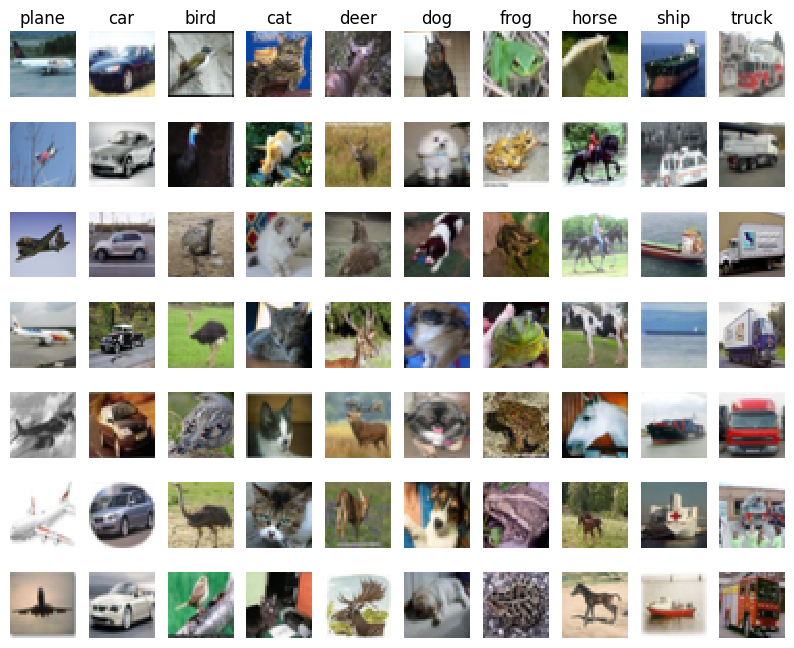

In [25]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

50000개 + 10000개 = 60000개의 데이터를 다루기엔 너무 시간이 많이 필요하니, 적당히 데이터의 크기를 조절해 줍니다.

In [26]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

**<span style="color:red"> 3. </span>** KNN 분류기를 만들고, 데이터를 넣어줍니다.

In [27]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    # 이미지 간 거리를 구하는 코드 
    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
 
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j]- X[i])))

        return dists
    
    # 가장 가까운 k개의 label을 선택, 투표
    def predict_labels(self, dists, k=1):
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[dists[i].argsort()[:k]]
            y_pred[i]= np.argmax(np.bincount(closest_y))
        return y_pred


classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

**<span style="color:red"> 4. </span>** 우리의 test 데이터와 KNN 안에 있는 train 데이터와의 거리를 계산합니다.  

In [28]:
dists = classifier.compute_distances(X_test)

**<span style="color:red"> [퀴즈] </span>** 만약 학습에 이용했던 데이터를 예측하는 test 데이터로 사용하면 어떤 일이 일어날까요?   
(k가 1일 때와 아닐 때로 구분해서 생각해봅시다!)

**<span style="color:red"> [정답] </span>** 

k=1일 때, 테스트 데이터가 학습 데이터와 같으므로 자기 자신과의 거리가 0이 된다. 그러면 가장 가까운 이웃이 자기 자신이 된다. 따라서, 예측 결과는 반드시 자기 자신의 정답 레이블과 동일하며 결과적으로 100% 정확도를 가진다.
k>1일 때, 위의 경우처럼 자기 자신을 이웃을 가지게 된다. 하지만 다른 이웃들의 영향 또한 받으므로 k=1일 때보다는 조금 더 일반화된 판단을 할 수 있다.

**<span style="color:red"> 5. </span>** 구한 거리를 바탕으로 test 데이터의 이미지가 어떤 이미지인지 예측하고 정확도를 구합니다.

In [29]:
# 모든 test 데이터를 예측
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 88 / 500 correct => accuracy: 0.176000


**<span style="color:red"> 6. </span>** K가 5일 때도 해봅시다

In [30]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 100 / 500 correct => accuracy: 0.200000


**<span style="color:red"> 7. </span>** 특정 이미지를 분류한 결과를 볼까요?

(5, 32, 32, 3)


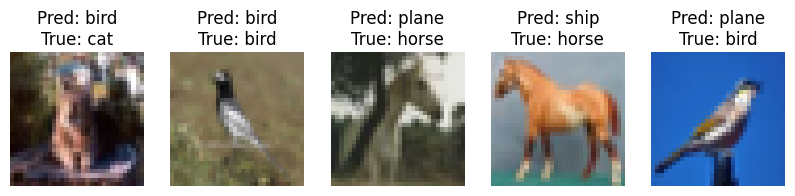

In [31]:
random.seed(1)
num_samples = 5
indices = random.sample(range(X_test.shape[0]), num_samples)
X_check = X_test[indices]
y_check = y_test[indices]

y_pred = classifier.predict(X_check, k = 5)

X_check = np.reshape(X_check, (5, 32, 32, 3))
print(X_check.shape)

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))  # 1행 5열로 이미지 배치
for i, ax in enumerate(axes):
    ax.imshow(X_check[i])  # 이미지 표시
    ax.axis('off')  # 축 숨기기
    ax.set_title(f"Pred: {classes[int(y_pred[i])]}\nTrue: {classes[y_check[i]]}")  # 예측값 & 정답 표시



이미지가 잘 분류 되었나요??

5개 중에 1개의 이미지만 올바르게 분류되었다. K=5일때 정확도가 0.2였으므로 정확한 이미지 분류를 기대하기 어렵다.

**<span style="color:brown"> [설문] </span>** 혹시 인공지능에 대해 얼마나 알고 계신가요?? 설명 가능한 단어를 모두 골라주세요  
<span style="color:violet"> 1. </span> 배치 정규화  
<span style="color:violet"> 2. </span> 활성화 함수  
<span style="color:violet"> 3. </span> 과적합  
<span style="color:violet"> 4. </span> 앙상블 학습  
<span style="color:violet"> 5. </span> 드롭아웃  
<span style="color:violet"> 6. </span> 어텐션 매커니즘  

인공지능에 대해 아는 게 없습니다....

## 1주차 과제 끝!
1주차 과제는 여기까지 입니다! 1주차 과제는 간단한 실습 위주로 준비해봤습니다.  

수업 중 이해가 안가거나 어려웠던 부분, 수업에 관한 피드백을 적어주시면 다음 주차 강의에 적극적으로 반영하겠습니다!

수업시간에 실습을 같이 진행하면 좋을 것 같습니다.